# Weather Image Recognition

## Obtendo os dados

In [1]:
# Instalando o split-folders
!pip install split-folders

In [2]:
import os
import zipfile
from pathlib import Path

# Configura caminho para a pasta de dados
data_path = Path("data/")
image_path = data_path / "images"

# Se a pasta de imagens não existir, baixe-a e prepare-a...
if image_path.is_dir():
    print(f"[INFO] {image_path} diretório existe.")
else:
    print(f"[INFO] Não encontramos o diretório {image_path}, criando um...")
    image_path.mkdir(parents=True, exist_ok=True)

# Define o caminho correto para o arquivo ZIP
zip_path = image_path / "weather-dataset.zip"

# Baixa o dataset se ele ainda não existir
if not zip_path.exists():
    print("Baixando weather data...")

    # Baixa o dataset usando o Kaggle CLI
    os.system(f"kaggle datasets download -d jehanbhathena/weather-dataset -p {image_path}")

    # Verifica se o arquivo foi baixado corretamente
    if zip_path.exists():
        print("[INFO] Download completo.")
    else:
        print("[ERROR] O download falhou. Verifique se o Kaggle CLI está configurado corretamente.")
else:
    print("[INFO] O dataset já foi baixado.")

# Extrai o arquivo ZIP para a pasta de imagens
if zip_path.exists():
    print("Extracting data...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(image_path)
    print("[INFO] Extração concluída.")

# Após a extração, agora ajusta o caminho correto para a pasta 'weather-dataset'
image_path = image_path / 'dataset'

# Verifica se as subpastas de classe existem dentro de image_path
if not any(os.path.isdir(os.path.join(image_path, subfolder)) for subfolder in os.listdir(image_path)):
    print(f"[ERROR] Não encontrei subpastas de classes dentro de {image_path}. O dataset pode não estar organizado corretamente.")
else:
    print(f"[INFO] O dataset está organizado corretamente com subpastas.")

# Divide o dataset em treino, validação e teste (80%, 10%, 10%)
import splitfolders
splitfolders.ratio(image_path, output="output_folder", seed=42, ratio=(0.8, 0.1, 0.1))

[INFO] Não encontramos o diretório data/images, criando um...
Baixando weather data...
[INFO] Download completo.
Extracting data...
[INFO] Extração concluída.
[INFO] O dataset está organizado corretamente com subpastas.


Copying files: 6862 files [00:03, 2266.77 files/s]


## Conhecendo os dados

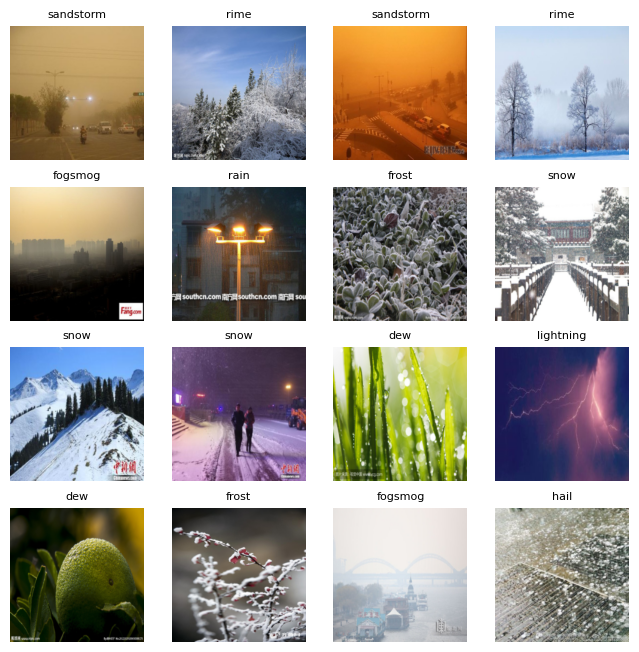

In [3]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch

# Definindo o número de batches e num_workers
batch_size = 32
num_workers = os.cpu_count()

# Cria as transformações de imagem
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # Redimensionando a imagem
    transforms.ToTensor(),  # Transformando a imagem em tensor
])

# Cria os datasets de treino, validação e teste
train_dataset = datasets.ImageFolder(root = '/content/output_folder/train', transform = data_transform)
test_dataset = datasets.ImageFolder(root = '/content/output_folder/test', transform = data_transform)
val_dataset = datasets.ImageFolder(root = '/content/output_folder/val', transform = data_transform)

# Número de classes
class_names = train_dataset.classes

# Definindo a seed para garantir a reprodutibilidade dos resultados
torch.manual_seed(42)

# Configurando o tamanho da figura para exibir as imagens
fig = plt.figure(figsize=(8, 8))

# Definindo a grade de visualização com 3 linhas e 3 colunas
rows, cols = 4, 4

# Loop para exibir 9 imagens aleatórias do conjunto de dados de treinamento
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()  # Seleciona um índice aleatório
    img, label = train_dataset[random_idx]  # Obtém a imagem e o rótulo correspondentes

    # Adiciona um subplot para a imagem atual na grade de 3x3
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))  # permuta para colocar os canais de cor no final
    plt.title(class_names[label], fontsize=8)  # Define o título do subplot com o nome da classe
    plt.axis(False)  # Remove os eixos para uma visualização mais limpa

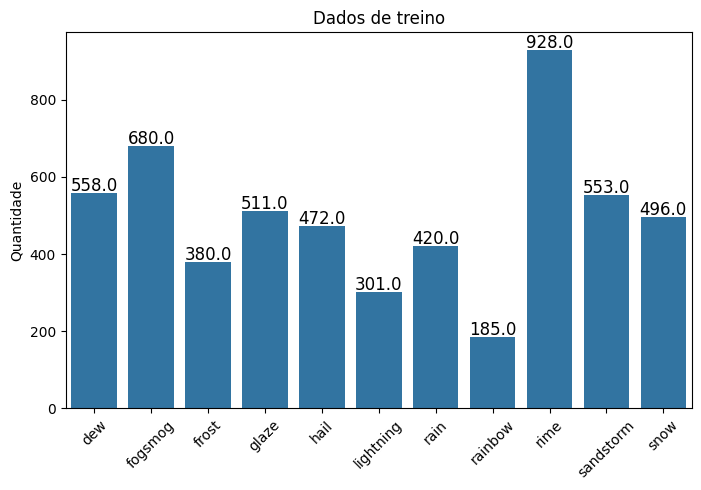

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Calculate class counts for train, test, and validation datasets
train_class_counts = Counter(train_dataset.targets)

# Criação dos DataFrames para os conjuntos de dados
df_train = pd.DataFrame(train_class_counts.items(), columns=['class', 'count'])
df_train['class'] = df_train['class'].map(lambda x: train_dataset.classes[x])

# Plotando as distribuições com seaborn
plt.figure(figsize=(20, 5))

# Função para adicionar os valores nas barras
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center',
                    fontsize = 12, color='black',
                    xytext = (0, 5),
                    textcoords='offset points')

# Plot para o conjunto de treinamento
plt.subplot(1, 3, 1)
ax_train = sns.barplot(x='class', y='count', data=df_train)
add_value_labels(ax_train)
plt.title('Dados de treino')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Quantidade')

plt.tight_layout()
plt.show()

## Criando dataset e dataloaders para o SwinTransformer

In [5]:
# Verificando se existe uma gpu
import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
weights = torchvision.models.Swin_V2_T_Weights.DEFAULT
model = torchvision.models.swin_v2_t(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:00<00:00, 158MB/s] 


In [7]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Definindo o número de batches e num_workers
batch_size = 32
num_workers = os.cpu_count()

# Cria as transformações de imagem
data_transform_swin = weights.transforms()

# Cria os datasets de treino, validação e teste
train_dataset = datasets.ImageFolder(root = '/content/output_folder/train', transform = data_transform_swin)
test_dataset = datasets.ImageFolder(root = '/content/output_folder/test', transform =data_transform_swin)
val_dataset = datasets.ImageFolder(root = '/content/output_folder/val', transform = data_transform_swin)

# Número de classes
class_names = train_dataset.classes

# Criando os dataloaders
train_dataloader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
test_dataloader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
val_dataloader = DataLoader(
      val_dataset,
      batch_size = batch_size,
      shuffle = False,
      num_workers = num_workers,
      pin_memory=True,
  )

print(f'[INFO] Foram encontrados {len(train_dataloader)} batches de dados de treino.')
print(f'[INFO] Foram encontrados {len(test_dataloader)} batches de dados de teste.')
print(f'[INFO] Foram encontrados {len(val_dataloader)} batches de dados de validação.')

[INFO] Foram encontrados 172 batches de dados de treino.
[INFO] Foram encontrados 22 batches de dados de teste.
[INFO] Foram encontrados 22 batches de dados de validação.


## Treinando o modelo

In [8]:
# Tente importar o diretório going_modular, baixe-o do GitHub se não funcionar
try:
    from going_modular.going_modular import data_setup, engine
except:
    print("[INFO] Não foi possível encontrar os scripts going_modular... baixando-os do GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Não foi possível encontrar os scripts going_modular... baixando-os do GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1456), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [9]:
# Obtendo a função plot_loss_curves() de helper_functions.py, baixe o arquivo se não existir...:
try:
    from helper_functions import plot_loss_curves
except ModuleNotFoundError:
    print("[INFO] Não foi possível encontrar helper_functions.py, baixando...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

[INFO] Não foi possível encontrar helper_functions.py, baixando...


In [10]:
for param in model.parameters():
  param.requires_grad = False

output_shape = len(class_names)

model.head = torch.nn.Linear(in_features = 768,
                    out_features = output_shape,
                    bias=True).to(device)

for param in model.head.parameters():
  param.requires_grad = True

In [11]:
# Treinando o modelo
from torch import nn

torch.cuda.manual_seed(42)
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = engine.train(model = model,
                train_dataloader = train_dataloader,
                test_dataloader = val_dataloader,
                optimizer = optimizer,
                loss_fn = loss_fn,
                epochs = 5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8078 | train_acc: 0.7795 | test_loss: 0.3985 | test_acc: 0.8875
Epoch: 2 | train_loss: 0.3938 | train_acc: 0.8883 | test_loss: 0.3097 | test_acc: 0.9020
Epoch: 3 | train_loss: 0.3184 | train_acc: 0.9059 | test_loss: 0.2768 | test_acc: 0.9077
Epoch: 4 | train_loss: 0.2737 | train_acc: 0.9172 | test_loss: 0.2555 | test_acc: 0.9162
Epoch: 5 | train_loss: 0.2508 | train_acc: 0.9248 | test_loss: 0.2498 | test_acc: 0.9176


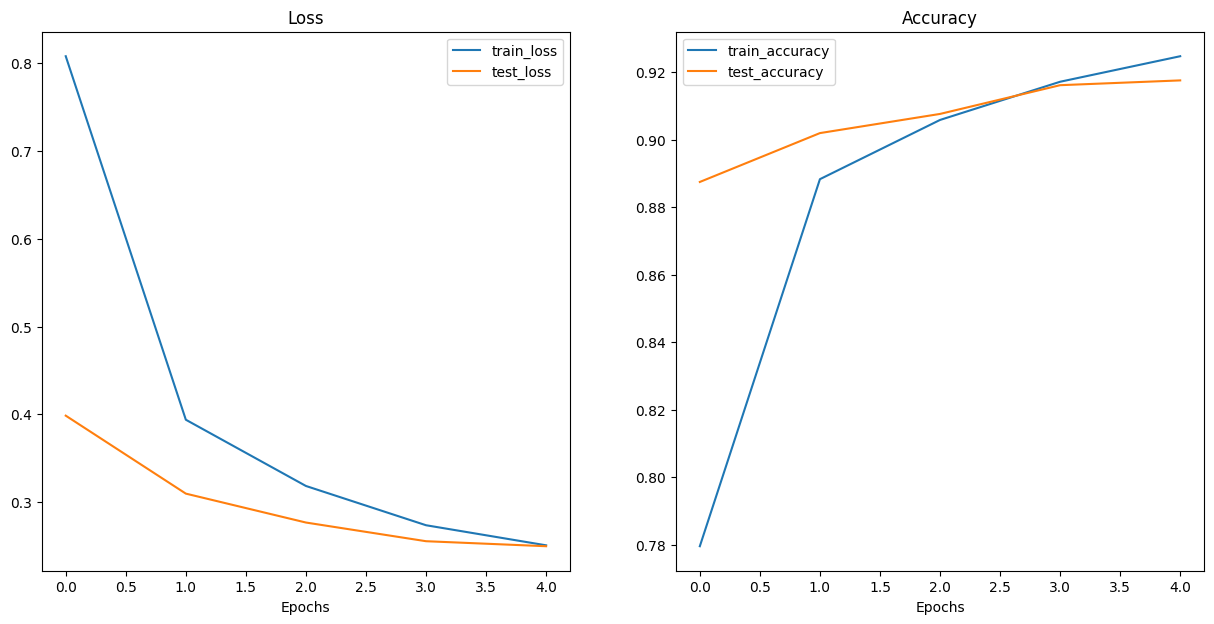

In [12]:
plot_loss_curves(results)

## Avaliando o modelo com a matriz de confusão

In [13]:
!pip install torchmetrics # Instala a biblioteca torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [14]:
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import MulticlassConfusionMatrix
from tqdm.auto import tqdm

# Avaliação do modelo
# Realizando previsões com o modelo treinado
y_preds = []  # Lista para armazenar as previsões

model.eval()  # Coloca o modelo em modo de avaliação (desabilita dropout e batch norm)

# Modo de inferência para garantir que não seja calculado o gradiente
with torch.inference_mode():
    # Itera sobre os dados de teste
    for X, y in tqdm(test_dataloader, desc = " Fazendo previsões..."):
        # Envia os dados e os alvos para o dispositivo de destino (GPU ou CPU)
        X, y = X.to(device), y.to(device)

        # Realiza a passagem direta (forward pass) pelo modelo
        y_logit = model(X)

        # Converte as previsões de logits para probabilidades (softmax) e, em seguida, para rótulos de previsão
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)  # Realiza softmax na dimensão dos logits, não na dimensão do batch (dim=1)

        # Coloca as previsões de volta na CPU para avaliação
        y_preds.append(y_pred.cpu())

# Concatena a lista de previsões em um tensor único
y_pred_tensor = torch.cat(y_preds)

 Fazendo previsões...:   0%|          | 0/22 [00:00<?, ?it/s]

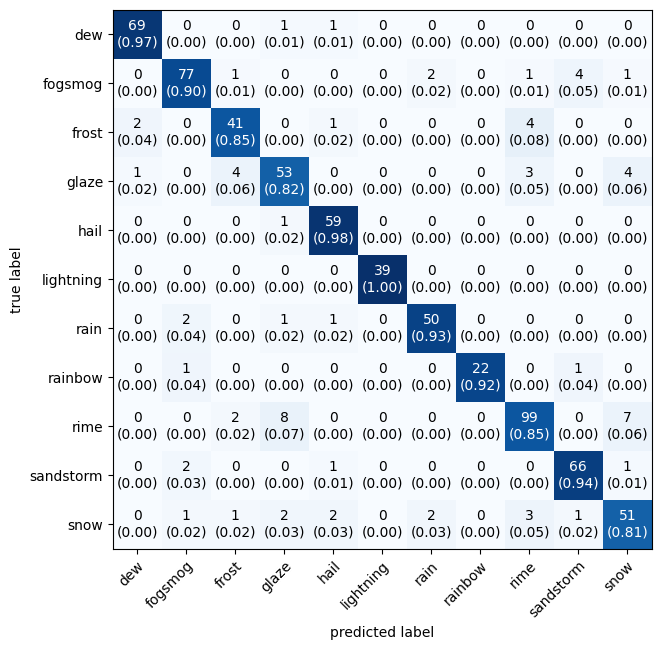

In [15]:
import torch
from tqdm.auto import tqdm
import mlxtend  # Biblioteca com diversas funcionalidades de machine learning, incluindo visualização de métricas
from mlxtend.plotting import plot_confusion_matrix  # Para plotar a matriz de confusão com mais detalhes

# Criação da instância da matriz de confusão para classificação binária
confmat = ConfusionMatrix(num_classes=len(class_names), task='MULTICLASS')

# Converte os labels de test_data para um tensor PyTorch
target_tensor = torch.tensor([target for _, target in test_dataloader.dataset], device=y_pred_tensor.device)

# Calcula a matriz de confusão utilizando as previsões e os labels convertidos
confmat_tensor = confmat(preds=y_pred_tensor, target=target_tensor)

# Plotando a matriz de confusão
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib trabalha melhor com arrays NumPy
    class_names=class_names,  # Transforma os rótulos das linhas e colunas em nomes de classes
    figsize=(10, 7),  # Define o tamanho da
    show_normed=True
);

## Fazendo previsões usando imagens do conjunto de teste

In [16]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Função para realizar a predição e exibir a imagem com a classe prevista
# Parâmetros:
# - model: Modelo treinado do PyTorch
# - image_path: Caminho da imagem a ser classificada
# - class_names: Lista de nomes das classes
# - image_size: Tamanho esperado da imagem (padrão: 224x224)
# - transform: Transformação opcional a ser aplicada na imagem
# - device: Dispositivo onde o modelo será executado (CPU ou GPU)
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = torch.device("cpu")):

    # 1. Abrindo a imagem a partir do caminho fornecido
    img = Image.open(image_path)

    # 2. Definindo a transformação da imagem, caso nenhuma tenha sido fornecida
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),  # Resizes the image
            transforms.ToTensor(),  # Converts to tensor
            transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    # 3. Garantindo que o modelo esteja no dispositivo correto
    model.to(device)

    # 4. Definindo o modelo em modo de avaliação e desativando o cálculo de gradientes
    model.eval()
    with torch.inference_mode():
        # 5. Aplicando a transformação e adicionando uma dimensão extra (batch_size=1)
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 6. Fazendo a predição e enviando a imagem para o dispositivo correto
        target_image_pred = model(transformed_image.to(device))

    # 7. Convertendo os logits em probabilidades usando softmax
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 8. Obtendo o índice da classe com maior probabilidade
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 9. Exibindo a imagem com a classe prevista e a probabilidade correspondente
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

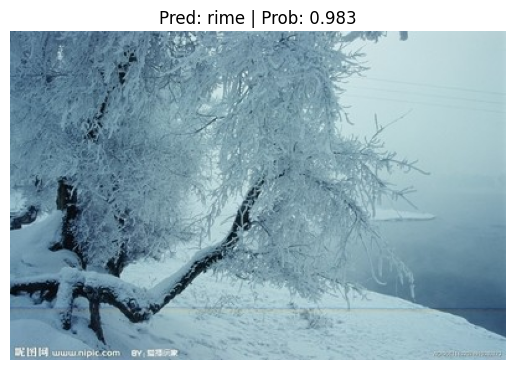

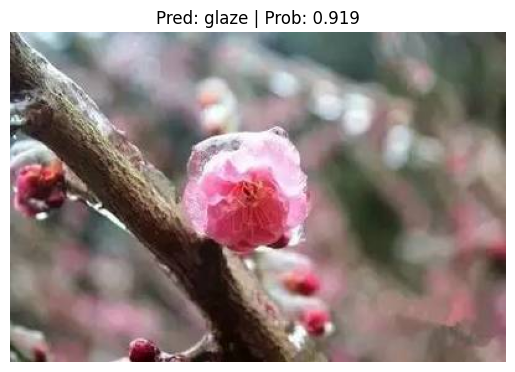

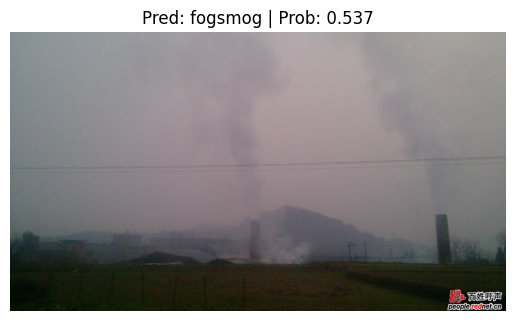

In [17]:
# Obtendo uma lista aleatória de caminhos de imagem do conjunto de teste
import random
num_images_to_plot = 3
test_image_path_list = list(Path('/content/output_folder/test').glob("*/*.jpg")) # obter lista de todos os caminhos de imagem dos dados de teste
test_image_path_sample = random.sample(population=test_image_path_list, # passe por todos os caminhos de imagem de teste
                                       k=num_images_to_plot) # selecionar aleatoriamente 'k' caminhos de imagem para pred e plotar

# Fazendo previsões e plotando as imagens do conjunto de teste
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        transform= weights.transforms(),
                        image_size=(260, 260))